# Handling Missing Data

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Dataset info
print(df.shape)
print(df.info())
df.head()

(7043, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [33]:
# Check null values
print(df.isnull().sum())

# Special check: blank strings in TotalCharges
blank_totalcharges = (df['TotalCharges'].str.strip() == "").sum()
print("Blank TotalCharges:", blank_totalcharges)

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64
Blank TotalCharges: 11


In [34]:
# Convert TotalCharges to numeric, forcing blanks to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Recheck missing count
print(df['TotalCharges'].isnull().sum())

11


In [35]:
# Fill with 0 if tenure = 0
df.loc[df['tenure'] == 0, 'TotalCharges'] = 0

# Group median imputation for others
df['TotalCharges'] = df.groupby('Contract')['TotalCharges'].transform(
    lambda x: x.fillna(x.median())
)

# Missing values after imputation
print(df['TotalCharges'].isnull().sum())

0


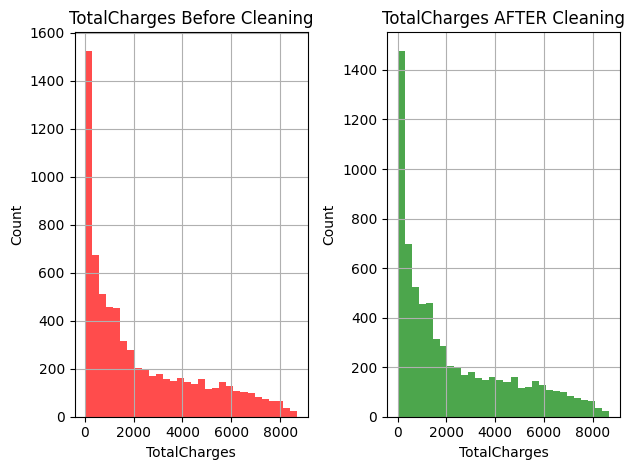

In [36]:
# Before vs after cleaning TotalCharges
df_before = pd.read_csv("../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df_before['TotalCharges'] = pd.to_numeric(df_before['TotalCharges'], errors='coerce')

# Before cleaning
plt.subplot(1,2,1)
df_before['TotalCharges'].hist(bins=30, color='red', alpha=0.7)
plt.title("TotalCharges Before Cleaning")
plt.xlabel("TotalCharges")
plt.ylabel("Count")

# After cleaning (imputed/dropped)
plt.subplot(1,2,2)
df['TotalCharges'].hist(bins=30, color='green', alpha=0.7)  # df is your cleaned version
plt.title("TotalCharges AFTER Cleaning")
plt.xlabel("TotalCharges")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

# Encoding Categorical Variables

In [37]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

In [38]:
df.drop('customerID', axis=1, inplace=True)

In [39]:
# Separate categorical and numeric columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print("Categorical columns:", categorical_cols)

Categorical columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']


In [40]:
# Label encoding for binary variables
binary_cols = [
    'gender', 'Partner', 'Dependents', 'PhoneService',
    'PaperlessBilling', 'Churn'
]

le = LabelEncoder()
for col in binary_cols:
    df[col] = le.fit_transform(df[col])

In [41]:
# Ordinal Encoding
contract_order = [['Month-to-month', 'One year', 'Two year']]
encoder = OrdinalEncoder(categories=contract_order)
df['Contract'] = encoder.fit_transform(df[['Contract']])

In [42]:
# One-Hot Encoding
df = pd.get_dummies(df, columns=['InternetService','PaymentMethod','MultipleLines','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies'])

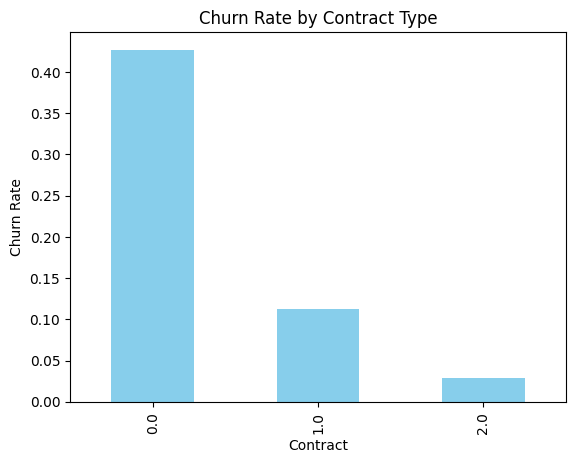

In [43]:
# Churn rate by Contract type
churn_by_contract = df.groupby('Contract')['Churn'].mean()

churn_by_contract.plot(kind='bar', color='skyblue')
plt.title("Churn Rate by Contract Type")
plt.ylabel("Churn Rate")
plt.show()

In [44]:
df.to_csv('../results/outputs/data_cleaned_encoded_telco_data.csv', index=False)